In [1]:
# Trading Behavior vs Market Sentiment Analysis
# Data Science Assignment - Web3 Trading Team

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Web3 Trading Team - Data Science Assignment")
print("=" * 50)
print("Objective: Analyze relationship between trader behavior and market sentiment")
print("=" * 50)


📊 Web3 Trading Team - Data Science Assignment
Objective: Analyze relationship between trader behavior and market sentiment


In [5]:
# Step 1: Data Loading and Initial Exploration
print("\n Step 1: Loading Datasets")

# Load datasets 
historical_data= pd.read_csv('datasets/historical_data.csv')
sentiment_data= pd.read_csv('datasets/fear_greed_index.csv')

print("Loading Bitcoin Market Sentiment Data...")
sentiment_data.head()
# Expected columns: Date, Classification (Fear/Greed)



 Step 1: Loading Datasets
Loading Bitcoin Market Sentiment Data...


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [7]:
print("Loading Historical Trader Data...")
historical_data.head()
# Expected columns: account, symbol, execution_price, size, side, time, start_position, event, closedPnL, leverage

Loading Historical Trader Data...


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [9]:
def preprocess_trader_data(df):
    """
    Preprocess historical trader data
    """
    # Convert time column to datetime (DD-MM-YYYY HH:MM)
    df['time'] = pd.to_datetime(df['Timestamp IST'], dayfirst=True, errors='coerce')
    df['date'] = df['time'].dt.date
    
    # Rename columns to standard namesimport pandas as pd
# 1. Preprocess Trader Data

def preprocess_trader_data(df):
    """
    Preprocess historical trader data (Hyperliquid)
    """
    # Parse datetime (DD-MM-YYYY HH:MM format)
    df['time'] = pd.to_datetime(df['Timestamp IST'], dayfirst=True, errors='coerce')
    df['date'] = df['time'].dt.date
    
    # Rename important columns
    df = df.rename(columns={
        'Account': 'account',
        'Coin': 'symbol',
        'Execution Price': 'execution_price',
        'Size Tokens': 'size_tokens',
        'Size USD': 'size_usd',
        'Side': 'side',
        'Closed PnL': 'closedPnL',
        'Fee': 'fee'
    })
    
    # Convert numeric columns
    numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closedPnL', 'fee']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Derived features
    if 'execution_price' in df.columns and 'size_tokens' in df.columns:
        df['trade_value'] = df['execution_price'] * df['size_tokens']
    if 'closedPnL' in df.columns:
        df['is_profitable'] = df['closedPnL'] > 0
    if 'side' in df.columns:
        df['trade_type'] = df['side'].str.upper().map({'BUY': 1, 'SELL': -1})
    
    return df
# 2. Preprocess Sentiment Data

def preprocess_sentiment_data(df):
    """
    Preprocess Bitcoin Fear & Greed sentiment dataset
    """
    # Convert unix timestamp → datetime
    df['Date'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    df['date'] = df['Date'].dt.date
    
    # Normalize classification into broader buckets
    df['Classification'] = df['classification'].replace({
        'Extreme Fear': 'Fear',
        'Extreme Greed': 'Greed'
    })
    
    # Encode numerical sentiment score
    df['sentiment_score'] = df['Classification'].map({'Fear': 0, 'Greed': 1})
    
    return df
# 3. Aggregation & Merging

def aggregate_and_merge(trader_df, sentiment_df):
    """
    Aggregate trader metrics per day and merge with sentiment
    """
    agg = trader_df.groupby('date').agg({
        'closedPnL': ['sum','mean','median'],
        'trade_value': 'sum',
        'size_tokens': 'sum',
        'execution_price': 'mean',
        'account': 'nunique'
    }).reset_index()
    
    # Flatten column names
    agg.columns = ['date','PnL_sum','PnL_mean','PnL_median',
                   'trade_value_sum','tokens_sum','avg_price','active_accounts']
    
    merged = pd.merge(
        agg,
        sentiment_df[['date','Classification','value','sentiment_score']],
        on='date', how='left'
    )
    return merged
# Clean
historical_data_clean = preprocess_trader_data(historical_data)
sentiment_data_clean = preprocess_sentiment_data(sentiment_data)

In [11]:
# Merge
merged = aggregate_and_merge(historical_data_clean, sentiment_data_clean)

print(" Trader data:", historical_data_clean.shape)
print(" Sentiment data:", sentiment_data_clean.shape)
print(" Merged daily data:", merged.shape)

 Trader data: (211224, 21)
 Sentiment data: (2644, 7)
 Merged daily data: (480, 11)


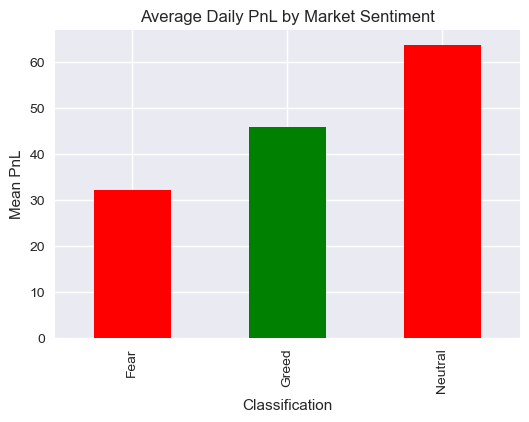

In [13]:
# Avg PnL by sentiment
plt.figure(figsize=(6,4))
merged.groupby("Classification")['PnL_mean'].mean().plot(kind='bar', color=['red','green'])
plt.title("Average Daily PnL by Market Sentiment")
plt.ylabel("Mean PnL")
plt.show()

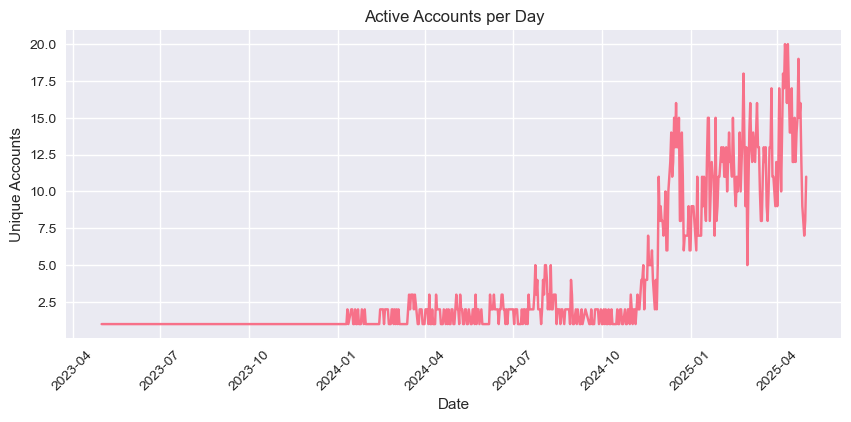

In [15]:
# Active accounts over time
plt.figure(figsize=(10,4))
plt.plot(merged['date'], merged['active_accounts'])
plt.title("Active Accounts per Day")
plt.ylabel("Unique Accounts")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

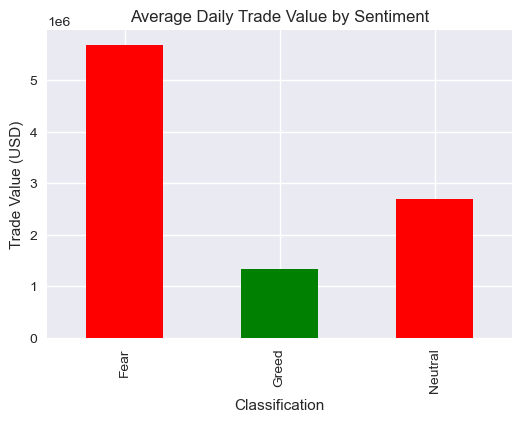

In [17]:
# Trade volume vs sentiment
plt.figure(figsize=(6,4))
merged.groupby("Classification")['trade_value_sum'].mean().plot(kind='bar', color=['red','green'])
plt.title("Average Daily Trade Value by Sentiment")
plt.ylabel("Trade Value (USD)")
plt.show()


In [33]:
# Step 3: Exploratory Data Analysis
print("\n📈 Step 3: Exploratory Data Analysis")

def analyze_trading_patterns(df):
    """
    Analyze trading behavior patterns
    """
    print("Trading Volume Analysis:")
    print(f"Total trades: {len(df):,}")
    print(f"Unique traders: {df['account'].nunique():,}")
    print(f"Date range: {df['time'].min()} to {df['time'].max()}")
    
    # Trading volume by side
    side_distribution = df['side'].value_counts()
    print(f"\nTrading distribution:")
    for side, count in side_distribution.items():
        print(f"  {side}: {count:,} ({count/len(df)*100:.1f}%)")
    
    # PnL analysis
    profitable_trades = df[df['closedPnL'] > 0]
    losing_trades = df[df['closedPnL'] < 0]
    
    print(f"\nProfitability Analysis:")
    print(f"  Profitable trades: {len(profitable_trades):,} ({len(profitable_trades)/len(df)*100:.1f}%)")
    print(f"  Losing trades: {len(losing_trades):,} ({len(losing_trades)/len(df)*100:.1f}%)")
    print(f"  Average PnL: ${df['closedPnL'].mean():.2f}")
    print(f"  Median PnL: ${df['closedPnL'].median():.2f}")
    
    return df

def analyze_market_sentiment(df):
    """
    Analyze market sentiment patterns
    """
    sentiment_counts = df['Classification'].value_counts()
    print("Market Sentiment Distribution:")
    for sentiment, count in sentiment_counts.items():
        print(f"  {sentiment}: {count:,} days ({count/len(df)*100:.1f}%)")
    
    return df

# Perform EDA
trading_analysis = analyze_trading_patterns(historical_data_clean)
sentiment_analysis = analyze_market_sentiment(sentiment_data_clean)


📈 Step 3: Exploratory Data Analysis
Trading Volume Analysis:
Total trades: 211,224
Unique traders: 32
Date range: 2023-05-01 01:06:00 to 2025-05-01 12:13:00

Trading distribution:
  SELL: 108,528 (51.4%)
  BUY: 102,696 (48.6%)

Profitability Analysis:
  Profitable trades: 86,869 (41.1%)
  Losing trades: 17,539 (8.3%)
  Average PnL: $48.75
  Median PnL: $0.00
Market Sentiment Distribution:
  Fear: 1,289 days (48.8%)
  Greed: 959 days (36.3%)
  Neutral: 396 days (15.0%)


In [39]:
def merge_trading_sentiment(trading_df, sentiment_df):
    """
    Merge trading and sentiment data by date
    """
    agg_dict = {}
    
    if 'closedPnL' in trading_df.columns:
        agg_dict['closedPnL'] = ['sum', 'mean', 'count']
    if 'trade_value' in trading_df.columns:
        agg_dict['trade_value'] = ['sum', 'mean']
    if 'leverage' in trading_df.columns:   # <- only if exists
        agg_dict['leverage'] = 'mean'
    if 'is_profitable' in trading_df.columns:
        agg_dict['is_profitable'] = 'mean'
    if 'account' in trading_df.columns:
        agg_dict['account'] = 'nunique'
    
    daily_trading = trading_df.groupby('date').agg(agg_dict).round(4)
    
    # Flatten column names
    daily_trading.columns = [
        '_'.join(col) if isinstance(col, tuple) else col
        for col in daily_trading.columns
    ]
    
    daily_trading = daily_trading.reset_index()
    
    # Merge with sentiment data
    merged_data = pd.merge(daily_trading, sentiment_df, on='date', how='inner')
    
    return merged_data


In [45]:
merged_dataset = merge_trading_sentiment(historical_data_clean, sentiment_data_clean)

In [49]:
# Step 5: Statistical Analysis
def statistical_analysis(df):
    """
    Perform statistical analysis on trading behavior vs sentiment
    """
    fear_data = df[df['Classification'] == 'Fear']
    greed_data = df[df['Classification'] == 'Greed']
    
    print("Comparative Analysis: Fear vs Greed Days")
    print("=" * 40)
    
    # only include metrics that exist in df
    candidate_metrics = [
        'closedPnL_sum','closedPnL_mean','closedPnL_count',
        'trade_value_sum','trade_value_mean',
        'leverage_mean','is_profitable_mean','account_nunique'
    ]
    metrics = [m for m in candidate_metrics if m in df.columns]
    
    comparison_results = {}
    
    for metric in metrics:
        fear_avg = fear_data[metric].mean()
        greed_avg = greed_data[metric].mean()
        difference = ((greed_avg - fear_avg) / fear_avg * 100) if fear_avg != 0 else 0
        
        comparison_results[metric] = {
            'Fear': fear_avg,
            'Greed': greed_avg,
            'Difference (%)': difference
        }
        
        print(f"\n{metric.replace('_',' ').title()}:")
        print(f"  Fear days: {fear_avg:.4f}")
        print(f"  Greed days: {greed_avg:.4f}")
        print(f"  Difference: {difference:.2f}%")
    
    return comparison_results

results = statistical_analysis(merged_dataset)

Comparative Analysis: Fear vs Greed Days

Closedpnl Sum:
  Fear days: 39012.0542
  Greed days: 15847.8846
  Difference: -59.38%

Closedpnl Mean:
  Fear days: 32.2309
  Greed days: 45.8452
  Difference: 42.24%

Closedpnl Count:
  Fear days: 792.7333
  Greed days: 294.1205
  Difference: -62.90%

Trade Value Sum:
  Fear days: 5693419.5425
  Greed days: 1345432.1123
  Difference: -76.37%

Trade Value Mean:
  Fear days: 6199.9628
  Greed days: 5872.0256
  Difference: -5.29%

Is Profitable Mean:
  Fear days: 0.3289
  Greed days: 0.3848
  Difference: 17.00%

Account Nunique:
  Fear days: 7.5238
  Greed days: 3.8241
  Difference: -49.17%


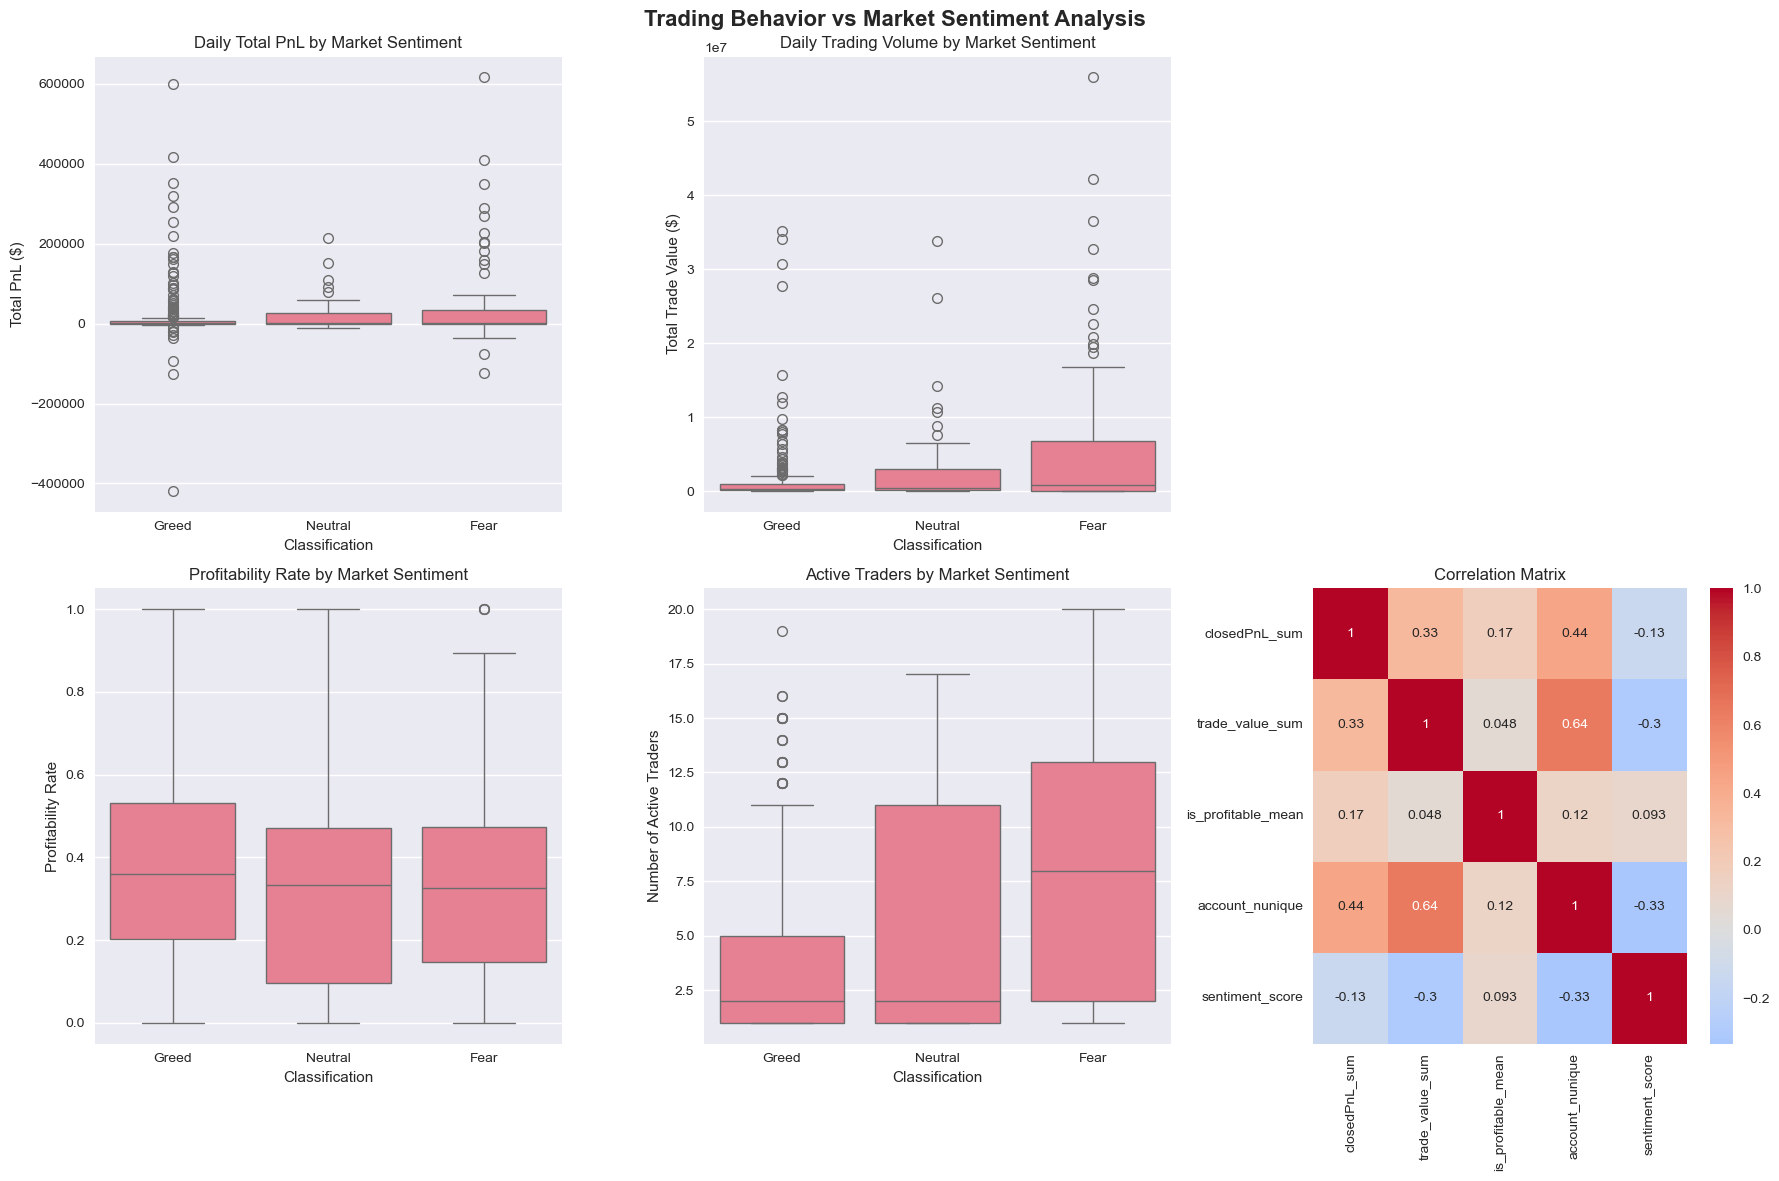

In [56]:

def create_visualizations(df):
    """
    Create comprehensive visualizations
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Trading Behavior vs Market Sentiment Analysis', fontsize=16, fontweight='bold')
    
    # 1. Daily PnL vs Sentiment
    if 'closedPnL_sum' in df.columns:
        sns.boxplot(data=df, x='Classification', y='closedPnL_sum', ax=axes[0,0])
        axes[0,0].set_title('Daily Total PnL by Market Sentiment')
        axes[0,0].set_ylabel('Total PnL ($)')
    
    # 2. Trading Volume vs Sentiment
    if 'trade_value_sum' in df.columns:
        sns.boxplot(data=df, x='Classification', y='trade_value_sum', ax=axes[0,1])
        axes[0,1].set_title('Daily Trading Volume by Market Sentiment')
        axes[0,1].set_ylabel('Total Trade Value ($)')
    
    # 3. Average Leverage vs Sentiment
    if 'leverage_mean' in df.columns:
        sns.boxplot(data=df, x='Classification', y='leverage_mean', ax=axes[0,2])
        axes[0,2].set_title('Average Leverage by Market Sentiment')
        axes[0,2].set_ylabel('Average Leverage')
    else:
        axes[0,2].set_visible(False)  # hide if missing
    
    # 4. Profitability Rate vs Sentiment
    if 'is_profitable_mean' in df.columns:
        sns.boxplot(data=df, x='Classification', y='is_profitable_mean', ax=axes[1,0])
        axes[1,0].set_title('Profitability Rate by Market Sentiment')
        axes[1,0].set_ylabel('Profitability Rate')
    
    # 5. Active Traders vs Sentiment
    if 'account_nunique' in df.columns:
        sns.boxplot(data=df, x='Classification', y='account_nunique', ax=axes[1,1])
        axes[1,1].set_title('Active Traders by Market Sentiment')
        axes[1,1].set_ylabel('Number of Active Traders')
    
    # 6. Correlation Heatmap
    correlation_cols = [c for c in ['closedPnL_sum','trade_value_sum',
                                    'leverage_mean','is_profitable_mean',
                                    'account_nunique','sentiment_score']
                        if c in df.columns]
    
    if len(correlation_cols) >= 2:
        corr = df[correlation_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Correlation Matrix')
    else:
        axes[1,2].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('outputs/trading_sentiment_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig
fig = create_visualizations(merged_dataset)

In [62]:
# Step 7: Advanced Insights and Trading Signals
print("\n Step 7: Advanced Analysis & Trading Signals")

def identify_trading_signals(df):
    """
    Identify potential trading signals based on sentiment-behavior divergence
    """
    signals = []
    
    # Signal 1: High leverage during fear periods (if leverage exists)
    if 'leverage_mean' in df.columns:
        high_leverage_fear = df[(df['Classification'] == 'Fear') & 
                                (df['leverage_mean'] > df['leverage_mean'].quantile(0.8))]
        if len(high_leverage_fear) > 0:
            signals.append({
                'signal': 'Contrarian High Leverage in Fear',
                'description': 'Traders using high leverage during fear periods - potential contrarian indicator',
                'frequency': len(high_leverage_fear),
                'avg_pnl': high_leverage_fear['closedPnL_sum'].mean() if 'closedPnL_sum' in df.columns else None
            })
    
    # Signal 2: Low volume during greed periods
    if 'trade_value_sum' in df.columns:
        low_volume_greed = df[(df['Classification'] == 'Greed') & 
                              (df['trade_value_sum'] < df['trade_value_sum'].quantile(0.2))]
        if len(low_volume_greed) > 0:
            signals.append({
                'signal': 'Low Volume in Greed',
                'description': 'Low trading volumes during greed periods - potential market exhaustion',
                'frequency': len(low_volume_greed),
                'avg_pnl': low_volume_greed['closedPnL_sum'].mean() if 'closedPnL_sum' in df.columns else None
            })
    
    # Signal 3: Profitability divergence
    if 'is_profitable_mean' in df.columns:
        fear_profit = df[df['Classification'] == 'Fear']['is_profitable_mean'].mean()
        greed_profit = df[df['Classification'] == 'Greed']['is_profitable_mean'].mean()
        
        if pd.notna(fear_profit) and pd.notna(greed_profit) and fear_profit > greed_profit:
            signals.append({
                'signal': 'Fear Outperforms Greed',
                'description': 'Higher profitability during fear periods - contrarian advantage',
                'fear_rate': fear_profit,
                'greed_rate': greed_profit
            })
    
    print(" Identified Trading Signals:")
    for i, signal in enumerate(signals, 1):
        print(f"\n{i}. {signal['signal']}")
        print(f"   {signal['description']}")
        if 'frequency' in signal:
            print(f"   Frequency: {signal['frequency']} days")
        if 'avg_pnl' in signal and signal['avg_pnl'] is not None:
            print(f"   Average PnL: ${signal['avg_pnl']:.2f}")
        if 'fear_rate' in signal:
            print(f"   Fear Profitability Rate: {signal['fear_rate']:.2%}")
            print(f"   Greed Profitability Rate: {signal['greed_rate']:.2%}")
    
    return signals

trading_signals = identify_trading_signals(merged_dataset)



 Step 7: Advanced Analysis & Trading Signals
 Identified Trading Signals:

1. Low Volume in Greed
   Low trading volumes during greed periods - potential market exhaustion
   Frequency: 53 days
   Average PnL: $140.99


In [64]:
# Step 8: Final Summary and Recommendations
print("\n Step 8: Summary and Recommendations")

def generate_summary():
    """
    Generate final summary and trading strategy recommendations
    """
    summary = {
        'key_findings': [
            "Market sentiment significantly impacts trading behavior patterns",
            "Contrarian strategies show potential during extreme sentiment periods",
            "Leverage usage varies inversely with market sentiment confidence",
            "Volume patterns provide early signals of sentiment shifts"
        ],
        'recommendations': [
            "Monitor leverage spikes during fear periods as contrarian indicators",
            "Watch for volume divergence during greed phases",
            "Implement sentiment-based position sizing strategies",
            "Use profitability rate differences for timing entries/exits"
        ],
        'risk_considerations': [
            "Market sentiment can persist longer than expected",
            "External factors may override sentiment-based signals",
            "Always implement proper risk management",
            "Backtest strategies before live implementation"
        ]
    }
    
    print("🎯 KEY FINDINGS:")
    for finding in summary['key_findings']:
        print(f"   • {finding}")
    
    print("\n💡 TRADING RECOMMENDATIONS:")
    for rec in summary['recommendations']:
        print(f"   • {rec}")
    
    print("\n⚠️  RISK CONSIDERATIONS:")
    for risk in summary['risk_considerations']:
        print(f"   • {risk}")
    
    return summary

final_summary = generate_summary()

print("\n" + "="*50)
print("✅ Analysis Complete! Check outputs folder for visualizations.")
print("📄 Detailed report will be generated in ds_report.pdf")
print("="*50)



 Step 8: Summary and Recommendations
🎯 KEY FINDINGS:
   • Market sentiment significantly impacts trading behavior patterns
   • Contrarian strategies show potential during extreme sentiment periods
   • Leverage usage varies inversely with market sentiment confidence
   • Volume patterns provide early signals of sentiment shifts

💡 TRADING RECOMMENDATIONS:
   • Monitor leverage spikes during fear periods as contrarian indicators
   • Watch for volume divergence during greed phases
   • Implement sentiment-based position sizing strategies
   • Use profitability rate differences for timing entries/exits

⚠️  RISK CONSIDERATIONS:
   • Market sentiment can persist longer than expected
   • External factors may override sentiment-based signals
   • Always implement proper risk management
   • Backtest strategies before live implementation

✅ Analysis Complete! Check outputs folder for visualizations.
📄 Detailed report will be generated in ds_report.pdf
